In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_memory_growth(gpus[0], True)
import nfp

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
print(f"tensorflow {tf.__version__}")
print(f"nfp {nfp.__version__}")

tensorflow 2.2.0
nfp 0.1.2


In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

from tqdm import tqdm
import itertools

import rdkit
import rdkit.Chem                                              

from molecule_builder import build_molecules

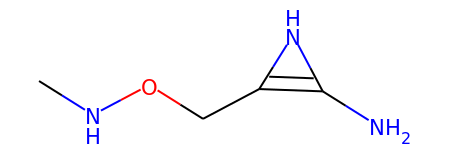

In [6]:
rng = np.random.default_rng(1)

def build(mol, num):
    """ Just builds a large molecule """
    for mol in build_molecules(mol, stereoisomers=False):
        if num == 1:
            yield mol
        else:
            yield from build(mol, num=num-1)

def build_random(low, high):
    return next(build(rdkit.Chem.MolFromSmiles('C'),
                      rng.integers(low=low, high=high, endpoint=True)))

build_random(6, 10)

## Initialize the preprocessor

I convert rdkit.Atoms and rdkit.Bonds into integer 'classes' for the neural network. The preprocessor class remembers the atom and bond types it's previously encountered; and just assigns new classes to an 'unknown' class. I can initialize this class by just generating a bunch of molecules and calling `construct_feature_matrices`.

We have to do this ahead of time, since we need to know how many rows to initialize in our embedding matrices when we create the neural network weights. This is a bit of a contrived example; typically I'll do all the preprocessing first, save the arrays as tfrecords files, and then run the GNN seperately. See [https://github.com/pstjohn/spin_gnn](https://github.com/pstjohn/spin_gnn) for an example of that approach

In [7]:
from gnn import preprocessor

for _ in tqdm(range(10000)):
    _ = preprocessor.construct_feature_matrices(build_random(6, 10), train=True)

100%|██████████| 10000/10000 [00:13<00:00, 738.72it/s]


In [8]:
preprocessor.atom_classes, preprocessor.bond_classes

(88, 114)

We can save the mapping between rdkit objects and integers with the preprocessor.to_json / from_json methods

*Preprocessor Output*:

`atom`: a list of atom classes
`bond`: a list of bond classes
`connectivity`: an array describing the molecule's graph. the *i*th row *(j,k)* indicates `bond[i]` connects `atom[j]` to `atom[k]`

In [9]:
preprocessor.construct_feature_matrices(build_random(6, 10), train=False)

{'atom': array([10, 14, 55, 11, 11,  9,  3]),
 'bond': array([25, 23, 13, 25, 22, 22, 24, 11, 14, 17, 10, 18]),
 'connectivity': array([[0, 1],
        [0, 3],
        [0, 4],
        [1, 0],
        [1, 2],
        [2, 1],
        [3, 0],
        [3, 5],
        [4, 0],
        [4, 6],
        [5, 3],
        [6, 4]])}

In [10]:
from rdkit.Chem.Descriptors import qed

def training_generator():
    while True:
        mol = build_random(6, 10)
        yield preprocessor.construct_feature_matrices(mol, train=False), qed(mol)

In [11]:
dataset = tf.data.Dataset.from_generator(
    training_generator,
    output_types=({'atom': tf.int64, 'bond': tf.int64, 'connectivity': tf.int64}, tf.float32),
    output_shapes=({'atom': [None,], 'bond': [None,], 'connectivity': [None, 2]}, []))\
    .padded_batch(batch_size=64, 
                  padded_shapes=({'atom': [-1], 'bond': [-1], 'connectivity': [-1, 2]}, []),
                  padding_values=({'atom': nfp.zero, 'bond': nfp.zero, 'connectivity': nfp.zero}, 0.))\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
from gnn import build_gnn_model

In [14]:
model = build_gnn_model(preprocessor)

In [15]:
model.fit(dataset, steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 17s 168ms/step - loss: 0.2228
Epoch 2/10
100/100 [==============================] - 17s 170ms/step - loss: 0.0870
Epoch 3/10
100/100 [==============================] - 17s 168ms/step - loss: 0.0667
Epoch 4/10
100/100 [==============================] - 17s 166ms/step - loss: 0.0544
Epoch 5/10
100/100 [==============================] - 17s 169ms/step - loss: 0.0510
Epoch 6/10
100/100 [==============================] - 17s 166ms/step - loss: 0.0470
Epoch 7/10
100/100 [==============================] - 17s 174ms/step - loss: 0.0456
Epoch 8/10
100/100 [==============================] - 17s 169ms/step - loss: 0.0484
Epoch 9/10
100/100 [==============================] - 17s 173ms/step - loss: 0.0422
Epoch 10/10
100/100 [==============================] - 17s 170ms/step - loss: 0.0417


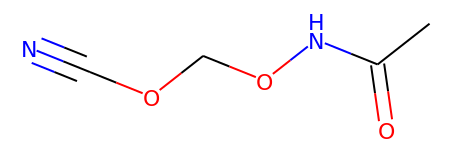

In [16]:
mol = build_random(6, 10)
mol

In [19]:
# We can't directly call model() on the output of `construct_feature_matrices`,
# since the model expects a batch dimension. We could go through the trouble of 
# creating the tf.dataset as shown above, or just fake it with expand_dims
model({key: np.expand_dims(val, 0) for key, val in 
       preprocessor.construct_feature_matrices(mol, train=False).items()})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.32621443]], dtype=float32)>